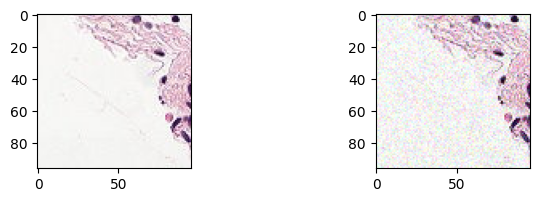

(32768, 96, 96, 3)
(32768, 2, 96, 96, 3)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py

def expand_dataset(data):
    expanded_data = []
    for i, image in enumerate(data):
        #im1 = tf.image.random_flip_left_right(image)
        #im2 = tf.image.random_flip_up_down(image)
        #im3 = tf.image.random_jpeg_quality(image, 80, 100)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=np.random.randint(10,30), dtype=tf.float32)Ы
        noisy_image = image + noise
        noisy_image = tf.clip_by_value(noisy_image, 0, 255)
        noisy_image = noisy_image.numpy().astype(np.uint8)

        expanded_data.append((noisy_image, image))

        
        if i == 0:
            fig, axes = plt.subplots(1, 2, figsize=(8, 2))
            axes[1].imshow(noisy_image)
            axes[0].imshow(image)
            #axes[1].imshow(im1)
            #axes[2].imshow(im2)
            #axes[3].imshow(im3)

            plt.show()
            
    return np.array(expanded_data)

filepath_x = 'data/camelyonpatch_level_2_split_test_x.h5'
with h5py.File(filepath_x, 'r') as f:
    data = f['x'][:]
    data = np.array(data)
#data = data[:32768]
expanded_data = expand_dataset(data)
print(data.shape)  # (32768, 96, 96, 3)
print(expanded_data.shape)  # (32768, 96, 96, 3)

dataset = tf.data.Dataset.from_tensor_slices(expanded_data)

dataset = dataset.map(lambda x: (tf.cast(x[0], tf.float32) / 255.0, tf.cast(x[1], tf.float32) / 255.0))

dataset = dataset.batch(64)


In [122]:
from tensorflow.keras import layers, Model

class Autoencoder5(Model):
    def __init__(self):
        super(Autoencoder5, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(96, 96, 3)),
            layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu'),
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),


            layers.Conv2D(128, (3, 3), padding='same',activation='sigmoid'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(3, 3, 128)),
            layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
            layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu'),
            layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


model = Autoencoder5()
input_shape = (1, 96, 96, 3)
model.build(input_shape)
model.summary()

loss_history = []

# model.encoder.summary()
# model.decoder.summary()

Model: "autoencoder5_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 3, 3, 128)         245968    
                                                                 
 sequential_7 (Sequential)   (None, 96, 96, 3)         244899    
                                                                 
Total params: 490,867
Trainable params: 490,867
Non-trainable params: 0
_________________________________________________________________


In [102]:
def reset_n_filter(n):
    # resets ns filter in encoder last layer
    last_conv_layer_weights = model.encoder.layers[-1].get_weights()
    print(last_conv_layer_weights[0][:, :, :, n])
    last_conv_layer_weights[0][:, :, :, n] = 0
    model.encoder.layers[-1].set_weights(last_conv_layer_weights)
    
reset_n_filter(79)

[[[-0.04277696  0.02829857  0.00142044 ... -0.05201545  0.02202776
    0.02585856]
  [-0.022438    0.02204243  0.02161971 ... -0.04818508  0.0443354
    0.03980008]
  [ 0.04357272  0.02812078  0.01885063 ...  0.01389646  0.05211072
   -0.03841425]]

 [[-0.03082646  0.03844567  0.00660796 ...  0.02549377  0.00950239
    0.01999007]
  [ 0.00230406  0.05755826 -0.0196043  ...  0.02128316 -0.00406971
    0.04404097]
  [-0.03994048 -0.0332485   0.00723702 ... -0.04030756 -0.02684184
   -0.00548238]]

 [[ 0.02170642 -0.02467282 -0.04313033 ... -0.02598253  0.04450497
    0.03601886]
  [ 0.02108376 -0.00813447 -0.01330463 ... -0.00574015  0.02325824
    0.02330765]
  [-0.05702069 -0.01590523 -0.02178152 ...  0.01196329  0.04168116
   -0.01654694]]]


In [127]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=tf.keras.losses.MSE)

history = model.fit(dataset, epochs=5, steps_per_epoch=len(dataset))

#todo epoch history plot

loss_history.extend(history.history['loss'])
# noize in input:  0.0147
# noize in output: 0.0155
# no noize:        0.0141

Epoch 1/5
512/512 [==============================] - 9s 15ms/step - loss: 0.0115
Epoch 2/5
512/512 [==============================] - 8s 16ms/step - loss: 0.0115
Epoch 3/5
512/512 [==============================] - 8s 16ms/step - loss: 0.0115
Epoch 4/5
512/512 [==============================] - 8s 16ms/step - loss: 0.0115
Epoch 5/5
512/512 [==============================] - 8s 16ms/step - loss: 0.0115


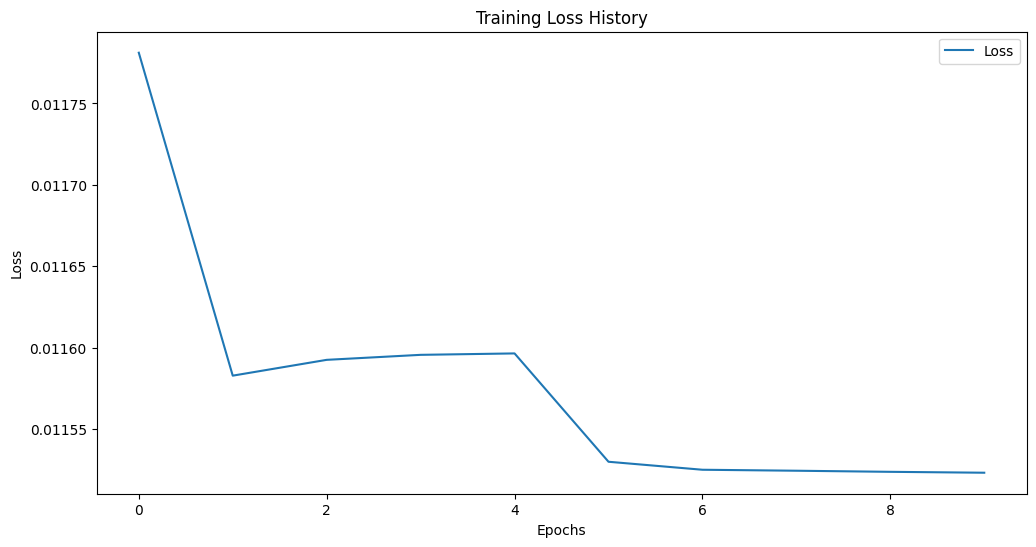

In [128]:
import matplotlib.pyplot as plt

# Построение графика истории потерь
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()


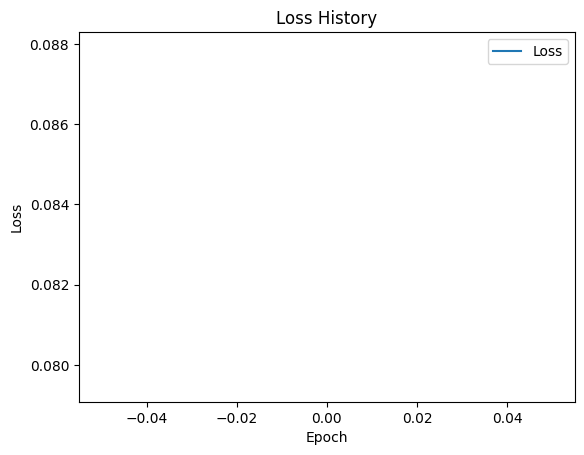

In [12]:

plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step


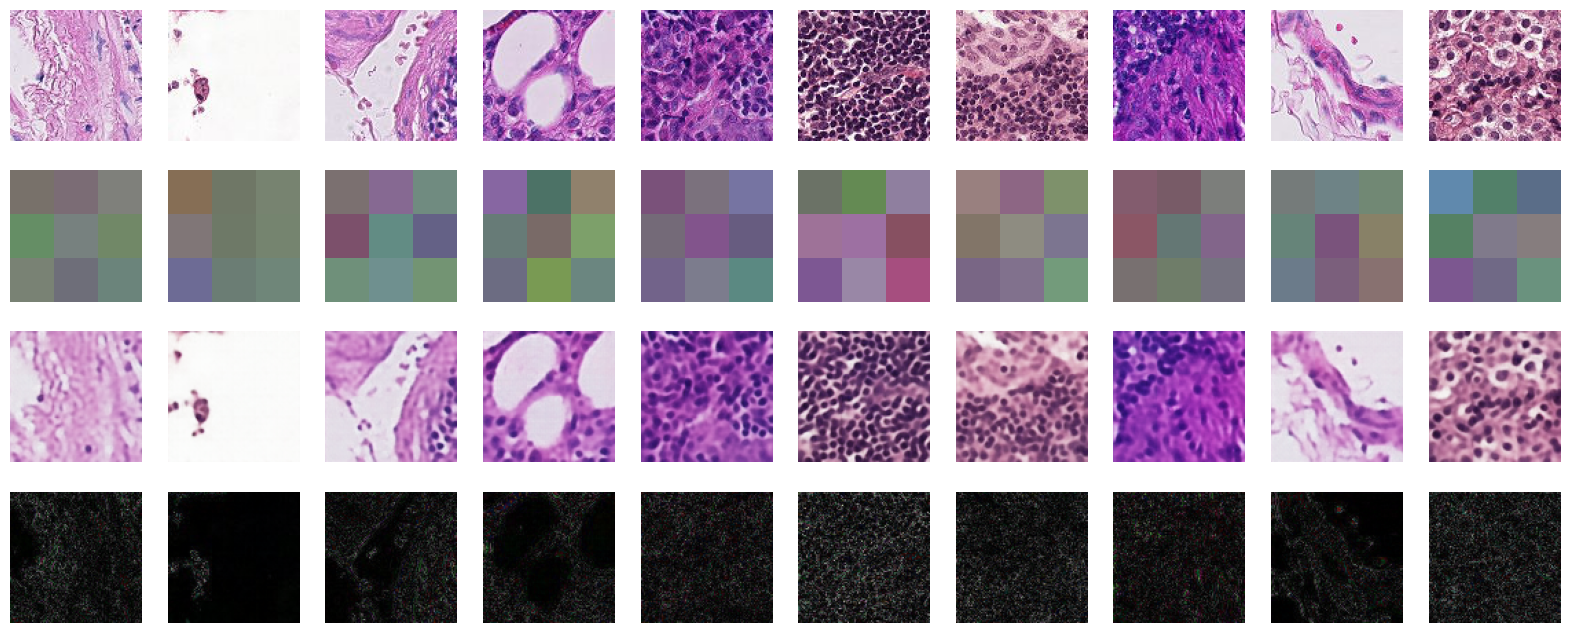

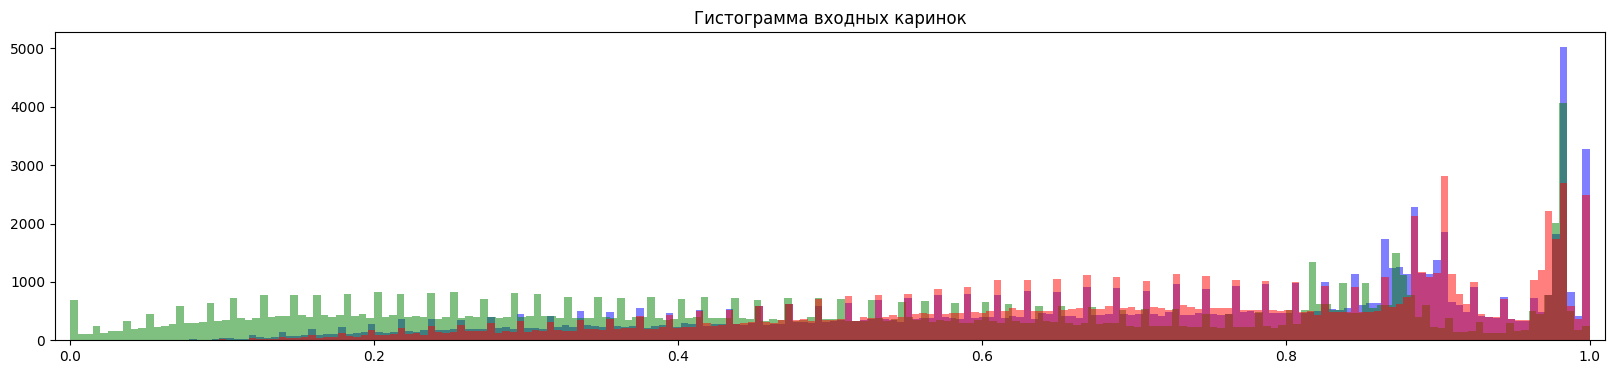

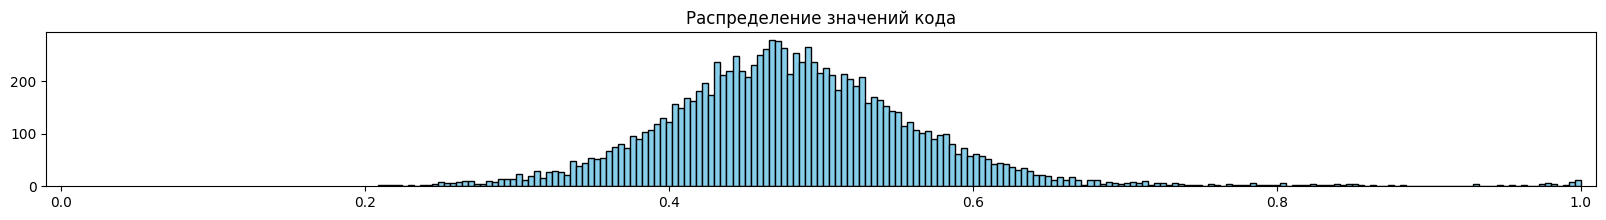

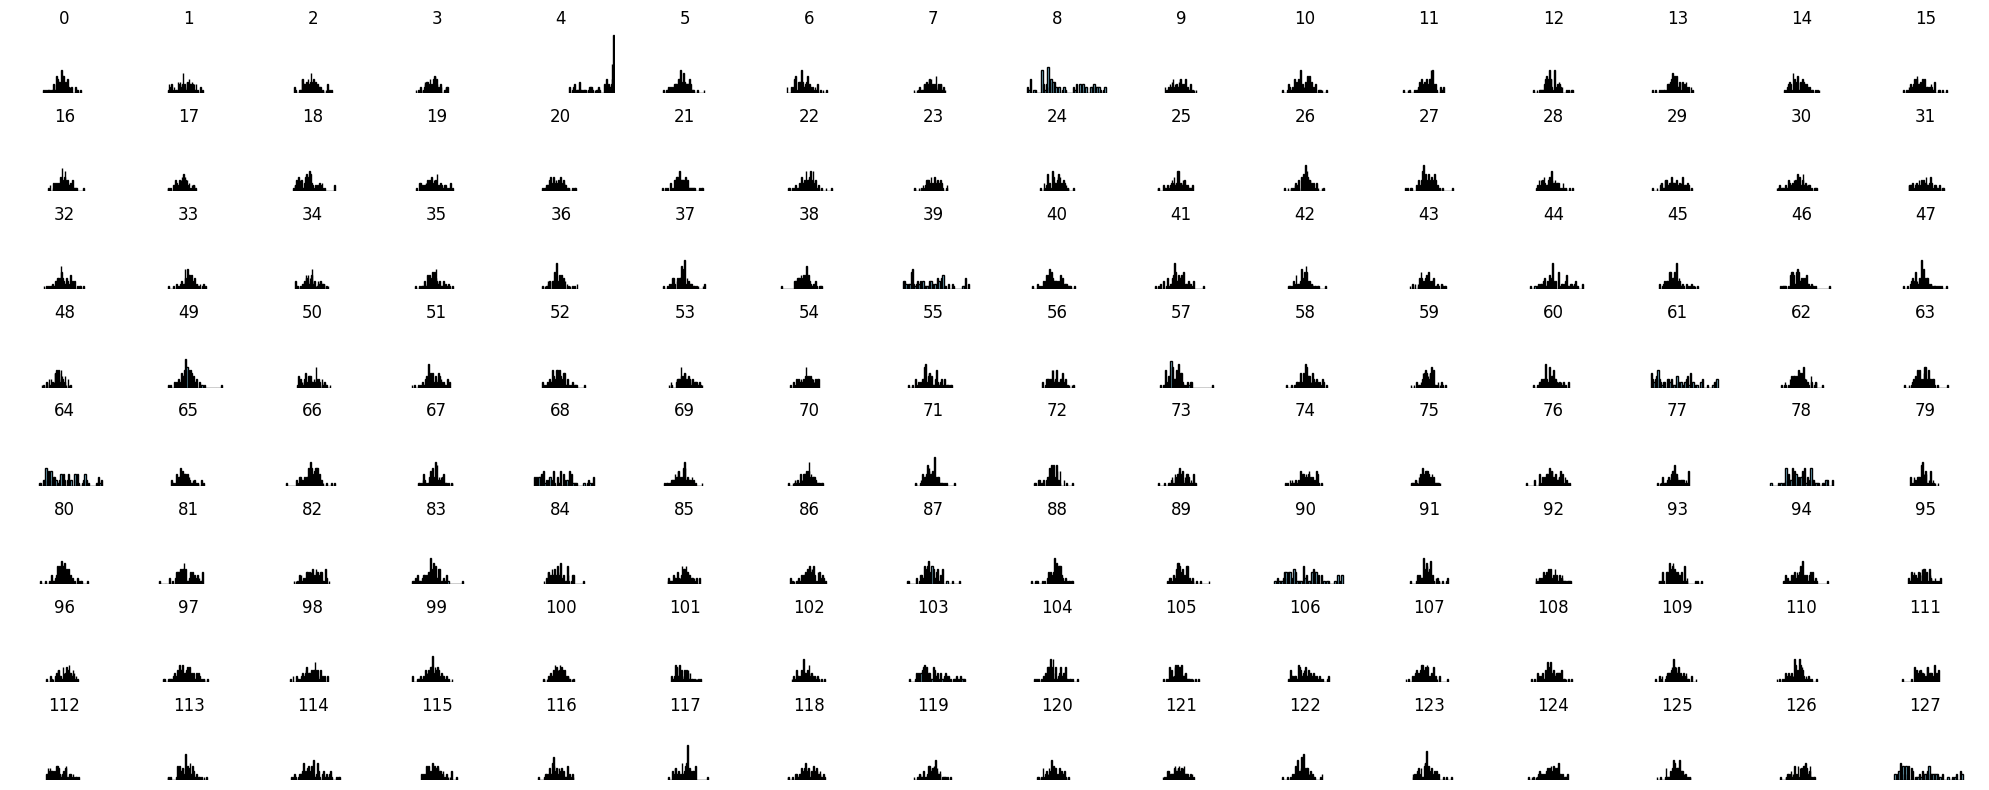

In [125]:
num = 10
images_in, images_out = next(iter(dataset.take(1)))
images = images_out
indices = np.random.choice(len(images), num, replace=False)
images = np.array([images[i] for i in indices])
reconstructed_images = (model.predict(images)) 
codes = model.encoder.predict(images[:num, :])

fig, axes = plt.subplots(4, num, figsize=(20, 8))
for i in range(num):
    axes[0, i].imshow(images[i])  
    axes[0, i].axis('off')
    try:
        axes[1, i].imshow(codes[i][:,:,:3]) 
        axes[1, i].axis('off')
    except:
        pass
    axes[2, i].imshow(reconstructed_images[i]) 
    axes[2, i].axis('off')
    axes[3, i].imshow(np.abs(reconstructed_images[i]-images[i]))
    axes[3, i].axis('off')

plt.show()

plt.figure(figsize=(20, 4))
plt.xlim([-0.01, 1.01])
plt.hist(images[:,:,:,0].reshape(-1), bins=200, color='blue', alpha = 0.5)
plt.hist(images[:,:,:,1].reshape(-1), bins=200, color='green', alpha = 0.5)
plt.hist(images[:,:,:,2].reshape(-1), bins=200, color='red', alpha = 0.5)
plt.title('Гистограмма входных каринок')
plt.show()

plt.figure(figsize=(20, 2))
plt.xlim([-0.01, 1.01])
plt.hist(codes.reshape(-1), bins=200, color='skyblue', edgecolor='black')
plt.title('Распределение значений кода')
plt.show()

num_channels = codes.shape[-1]
num_cols = 16  # Maximum number of plots per row
num_rows = num_channels // num_cols  # Calculate the number of rows automatically
if num_channels % num_cols!= 0:
    num_rows += 1  # Add an extra row if there are leftover channels

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8), sharey=True)
for i in range(num_channels):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')
    axes[row, col].set_xlim([-0.01, 1.01]) 
    axes[row, col].hist(codes[:, :, :, i].reshape(-1), bins=50, color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'{i}')

plt.tight_layout()
plt.show()

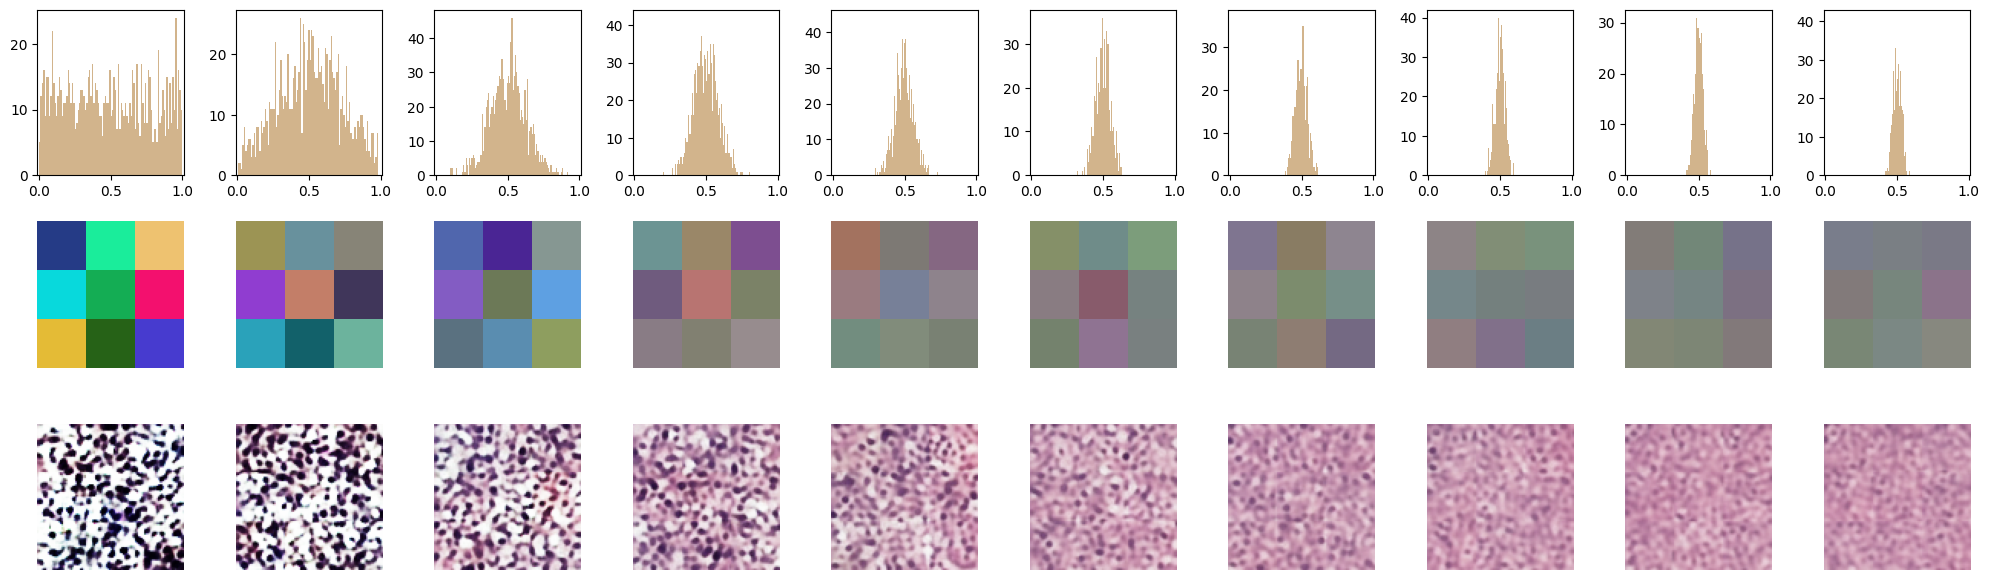

In [140]:
import numpy as np
import matplotlib.pyplot as plt


num = 10


input_shape = model.decoder.input_shape[1:]

def generate_image(i):
    a = i*2+0.01
    img = np.random.normal(0, 1, input_shape)
    img = img / a
    img = np.clip(img, -1, 1)
    img = img / 2 + 0.5
    img = np.where(img == 0, np.random.uniform(0, 1, img.shape), img)
    img = np.where(img == 1, np.random.uniform(0, 1, img.shape), img)
    return img

random_images = np.zeros((num, *input_shape))
for i in range(num):
    random_images[i] = generate_image(i)

reconstructed_images = model.decoder(random_images)

fig, axes = plt.subplots(3, num, figsize=(20, 6))
for i in range(num):
    axes[0, i].hist(random_images[i].flatten(), bins=100, color='tan')
    axes[0, i].set_xlim([-0.01, 1.01]) 

    axes[1, i].imshow(random_images[i, :, :, :3])
    axes[1, i].axis('off')
    
    axes[2, i].imshow(reconstructed_images[i, :, :, :3])
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


40/40 [==============================] - 0s 7ms/step


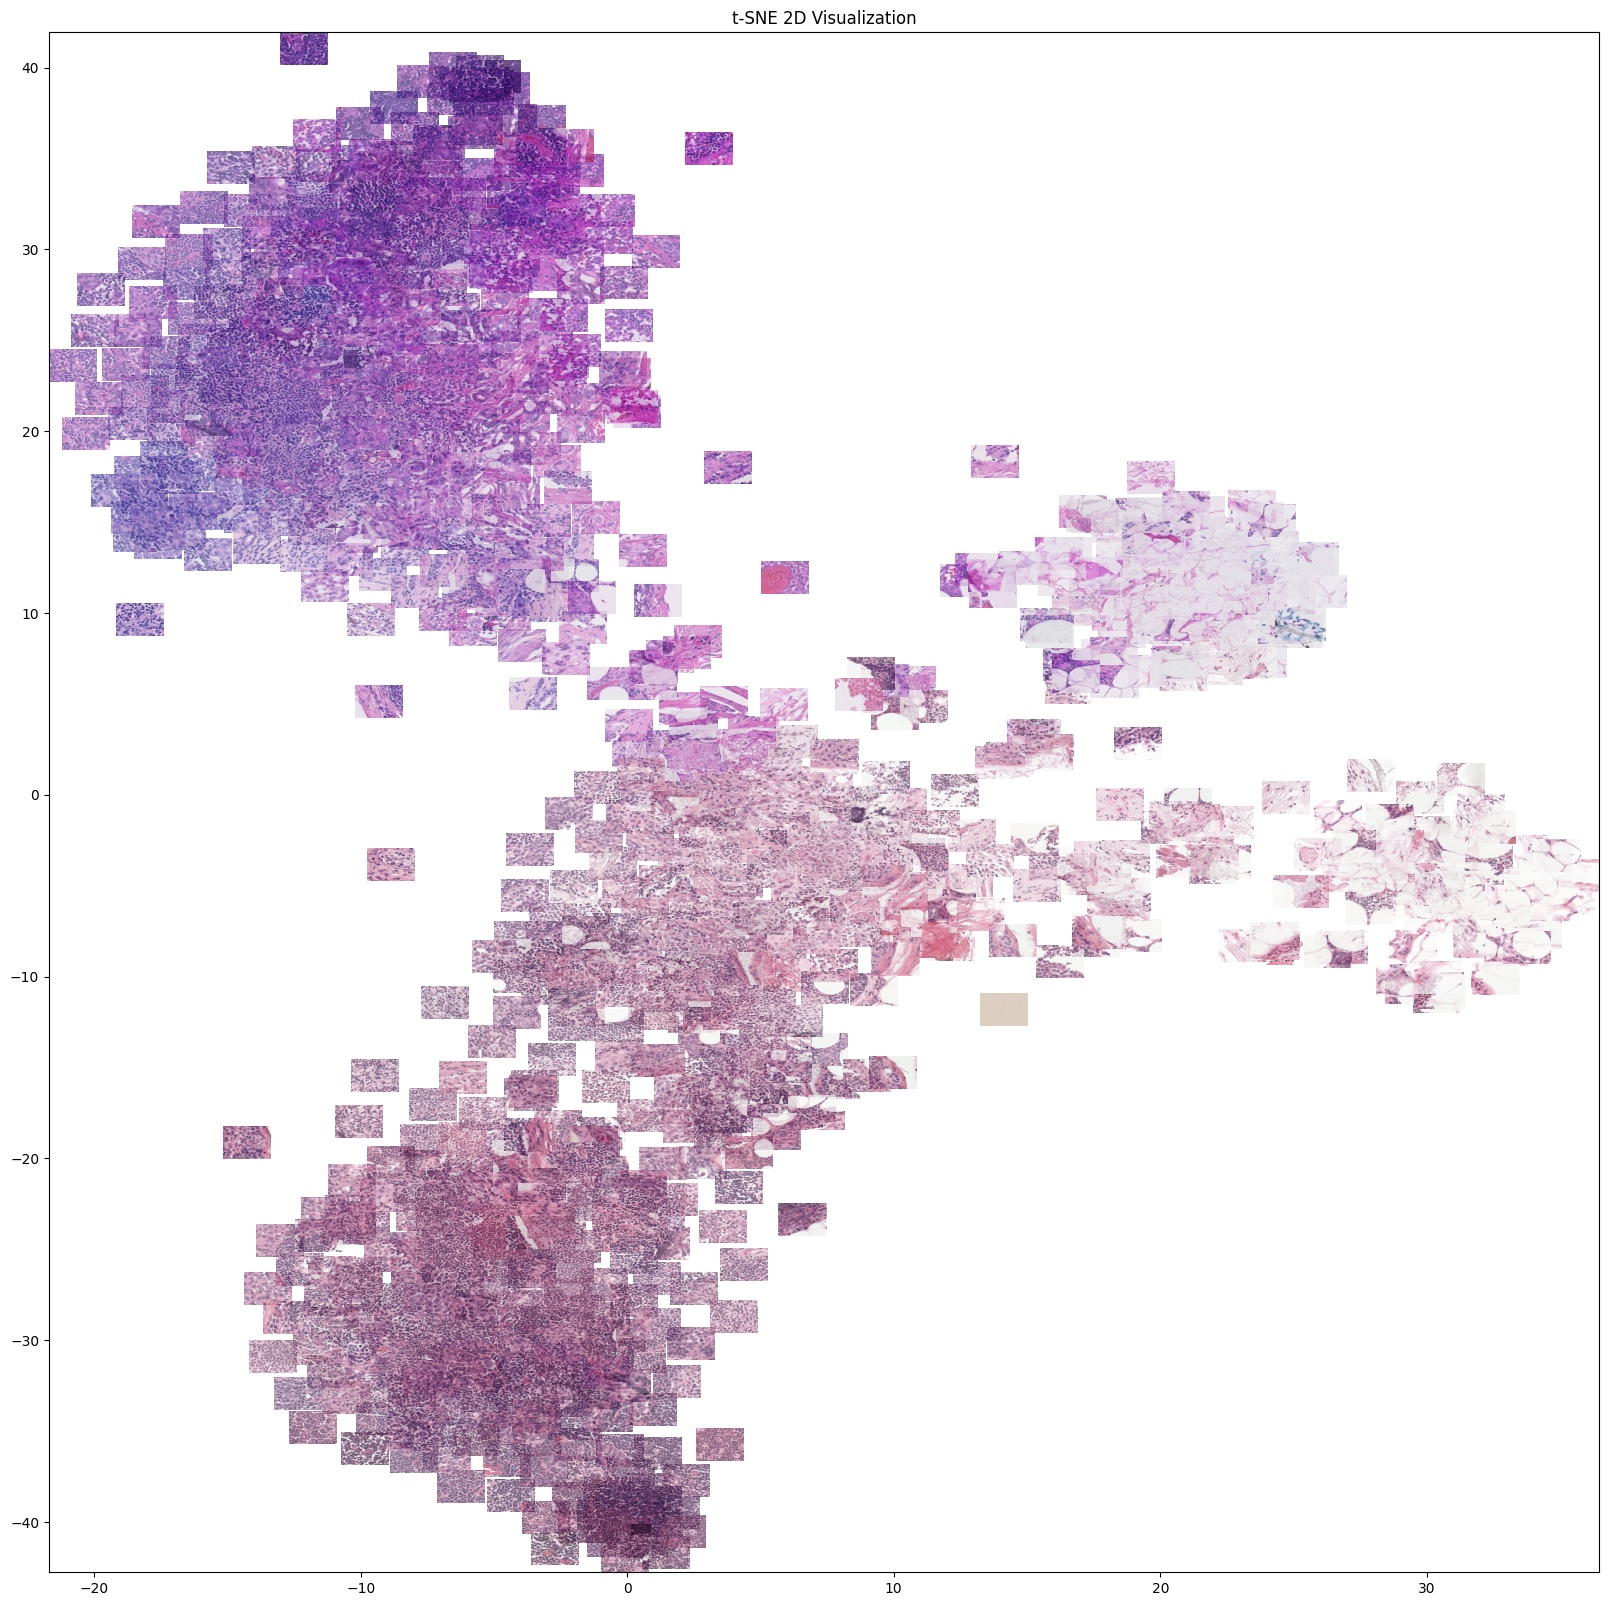

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

all_images = []
n_batches = 20

for i, (images_in, images_out) in enumerate(dataset.take(n_batches)):
    all_images.extend(images_out) 

images = np.array(all_images)
codes = model.encoder.predict(images)
mean_colors = np.mean(images, axis=(1, 2))
codes_2d = codes.reshape(codes.shape[0], -1)
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
reduced_codes = tsne.fit_transform(codes_2d)

fig2d = plt.figure(figsize=(20, 20))
ax2d = fig2d.add_subplot(111)
scatter2d = ax2d.scatter(reduced_codes[:, 0], reduced_codes[:, 1], c=range(len(all_images)), cmap='viridis', s=0)

def display_mini_images(ax, scatter, images, size=(1.8, 1.8)):
    for i, (x, y) in enumerate(scatter.get_offsets()):
        ax.imshow(images[i], extent=(x, x+size[0], y, y+size[1]), aspect='auto', alpha=0.7, zorder=0)
        ax.scatter(x, y, c='white', s=0, zorder=1)

display_mini_images(ax2d, scatter2d, images)

ax2d.set_title('t-SNE 2D Visualization')
plt.show()

1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


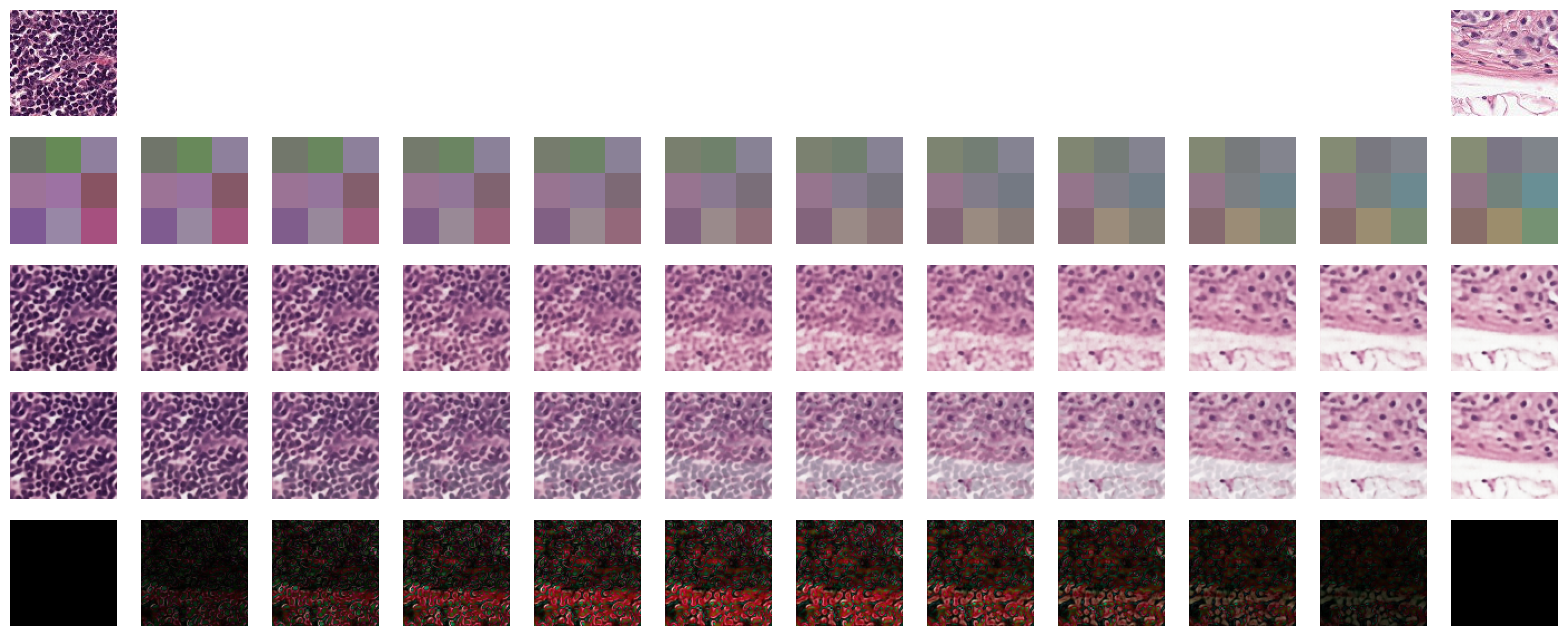

In [139]:
import matplotlib.pyplot as plt

def get_permutated_codes(steps, code_start, code_end):
    codes = []
    for i in range(steps):
        blend = i/(steps-1)
        code = code_start*(1-blend)+ code_end*blend
        codes.append(code)
    return np.array(codes)

def blend_images(blend, image_start, image_end):
    return image_start*(1-blend)+ image_end*blend


steps = 12



images_in, images_out = next(iter(dataset.take(1)))
indices = np.random.choice(len(images_out), 2, replace=False)
images_out = np.array([images_out[i] for i in indices])

image_start = images_out[0]
image_end = images_out[1]

codes = model.encoder.predict(images_out)

code_start = codes[0]
code_end = codes[1]

permutated_codes = get_permutated_codes(steps, code_start, code_end)
reconstructed_images = model.decoder.predict(permutated_codes)

fig, axes = plt.subplots(5, steps, figsize=(20, 8))
axes[0, 0].imshow(image_start) 
axes[0, steps-1].imshow(image_end) 

for i in range(steps):
    axes[0, i].axis('off')
    axes[1, i].imshow(permutated_codes[i,:,:,:3])  
    axes[1, i].axis('off')
    axes[2, i].imshow(reconstructed_images[i]) 
    axes[2, i].axis('off')
    blended_image = blend_images(i/(steps-1), reconstructed_images[0], reconstructed_images[-1])
    axes[3, i].imshow(blended_image) 
    axes[3, i].axis('off')
    axes[4, i].imshow(np.abs(blended_image - reconstructed_images[i])*4) 
    axes[4, i].axis('off')


plt.show()


## Save/load model

In [123]:
from tensorflow.keras.models import save_model, load_model

# model.save('checkpoints/lympha0015_3_3_128')
# model.save_weights('checkpoints/2lympha0015_3_3_128_weights.h5')

# loaded_model = tf.keras.models.load_model('checkpoints/lympha0015_3_3_128')
model.load_weights('checkpoints/lympha0015_3_3_128_weights.h5')

# model = load_model